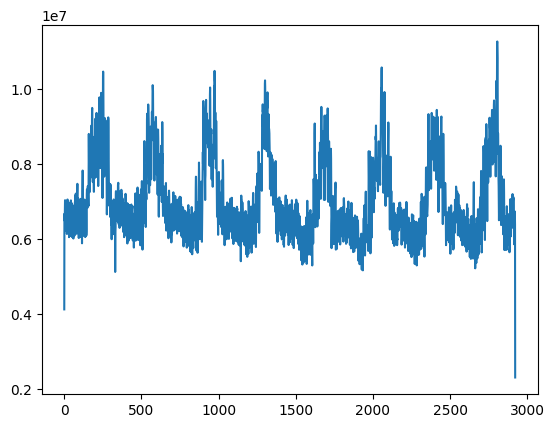

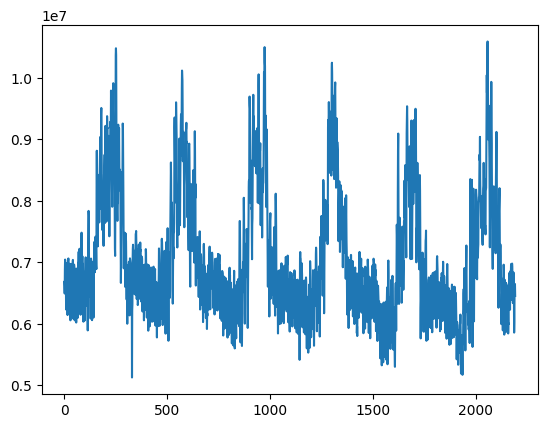

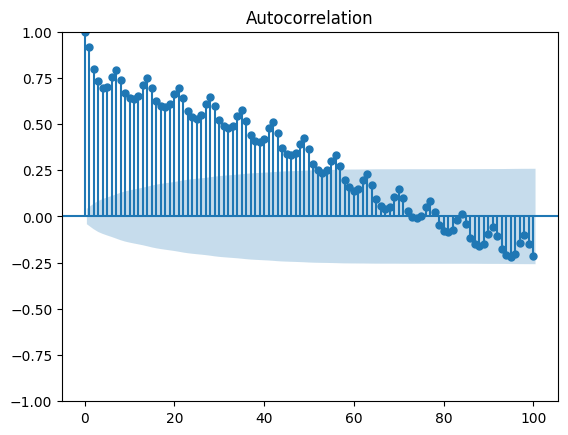

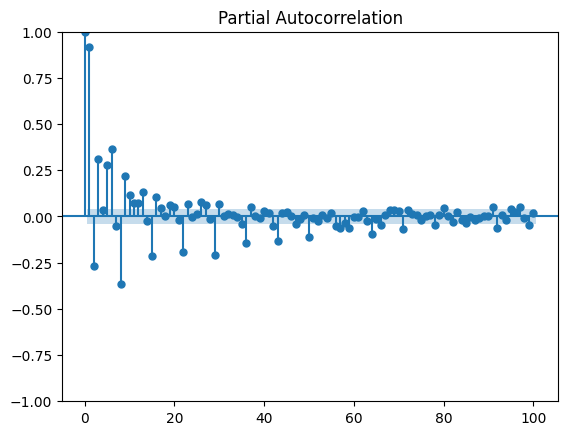

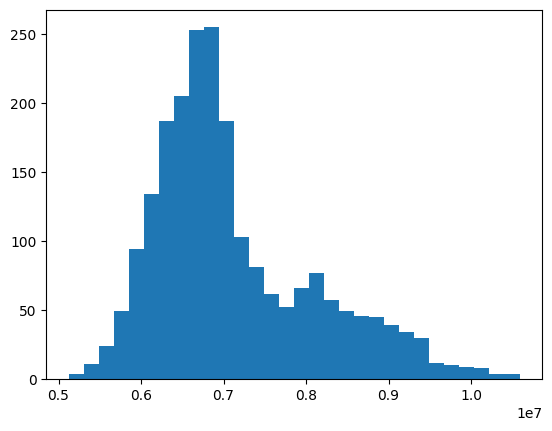

(-3.0125845553283206, 0.033735757660825, 26, 2164, {'1%': -3.4333754500434264, '5%': -2.862876536558312, '10%': -2.56748150557262}, 60293.41667559594)
/tmp/ipykernel_37/2910649079.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['first_diff'] = train['load_MW'].diff().dropna()


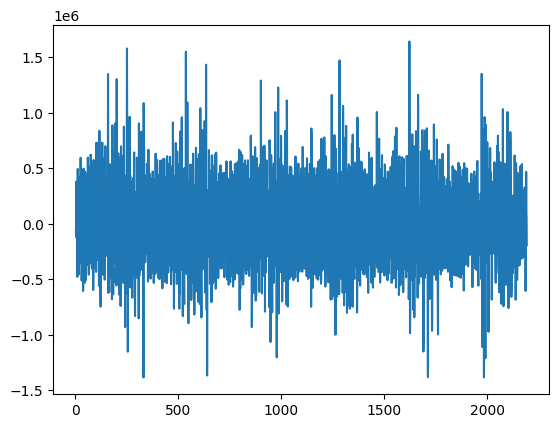

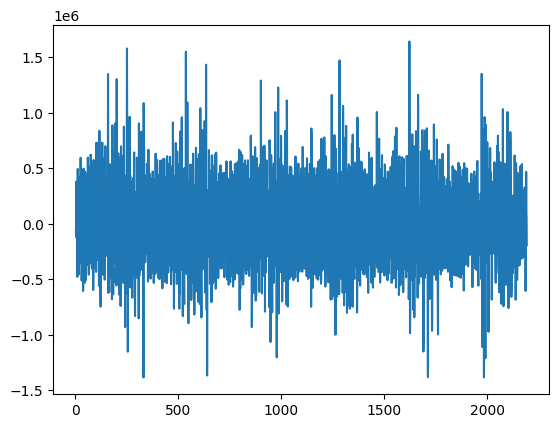

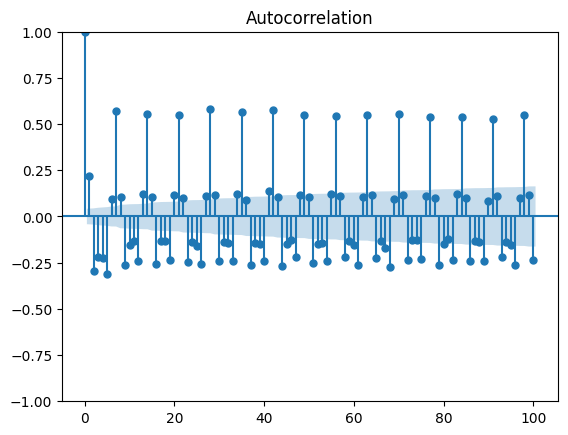

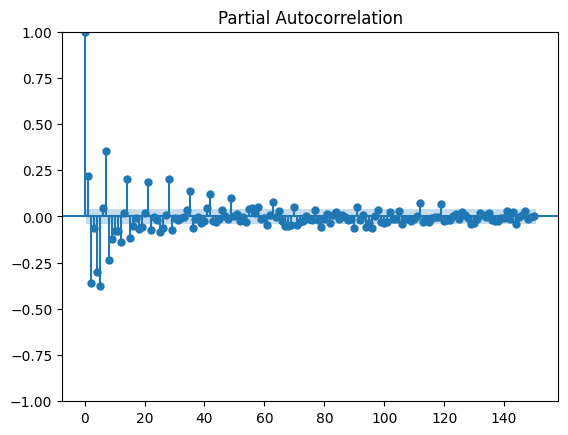

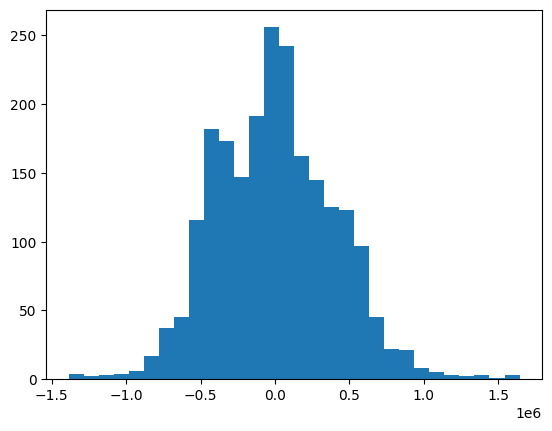

(-12.374922507126724, 5.181284691273868e-23, 25, 2164, {'1%': -3.4333754500434264, '5%': -2.862876536558312, '10%': -2.56748150557262}, 60273.09250853471)


In [5]:
# first text file


import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import STL
from pmdarima import auto_arima

# Load in and wrangle data
caiso_data = pd.read_csv("/work/CAISO_data.csv")

test_caiso = caiso_data.head(100).copy()
test_caiso['date'] = pd.to_datetime(test_caiso['timestamp'].str[:10])
test_caiso = test_caiso.groupby('date').agg({'load_MW': 'sum'}).reset_index()

use_data = caiso_data.copy()
use_data['date'] = pd.to_datetime(use_data['timestamp'].str[:10])
use_data = use_data.groupby('date').agg({'load_MW': 'sum'}).reset_index()

plt.plot(use_data['load_MW'])
plt.show()

# Train-Test Split 
train_size = int(len(use_data) * 0.75)
train, test = use_data.iloc[1:train_size], use_data.iloc[train_size:-1]

# Plotting functions similar to autoplot, ACF, PACF, and histogram in R
plt.plot(train['load_MW'])
plt.show()

plot_acf(train['load_MW'], lags=100)
plt.show()

plot_pacf(train['load_MW'], lags=100)
plt.show()

plt.hist(train['load_MW'], bins=30)
plt.show()

# ADF test
print(adfuller(train['load_MW']))

# Take first difference
train['first_diff'] = train['load_MW'].diff().dropna()

plt.plot(train['first_diff'])
plt.show()

# Repeating plots for differenced data
plt.plot(train['first_diff'])
plt.show()

plot_acf(train['first_diff'].dropna(), lags=100)
plt.show()

plot_pacf(train['first_diff'].dropna(), lags=150)
plt.show()

plt.hist(train['first_diff'].dropna(), bins=30)
plt.show()

# ADF test on differenced data
print(adfuller(train['first_diff'].dropna()))


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=6.69 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=64360.260, Time=0.07 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=63570.739, Time=2.69 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=4.99 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=64293.604, Time=0.20 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=63324.867, Time=7.37 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=18.83 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=6.87 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=63096.387, Time=5.80 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=63633.553, Time=2.01 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=16.91 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=6.51 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=63242.825, Time=8.09 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=63211.113, Time=14.51 sec
 ARIMA(0,1,0)(2,1,0)[12] intercept   :

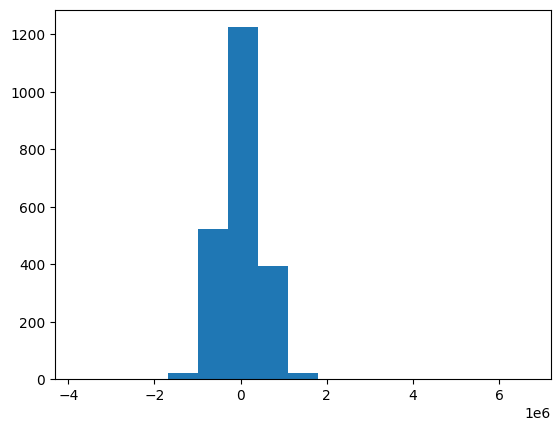

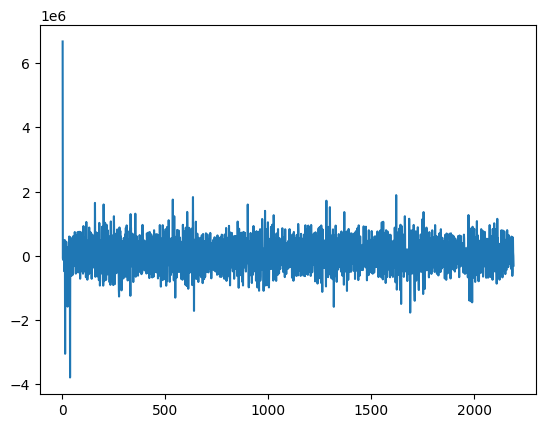

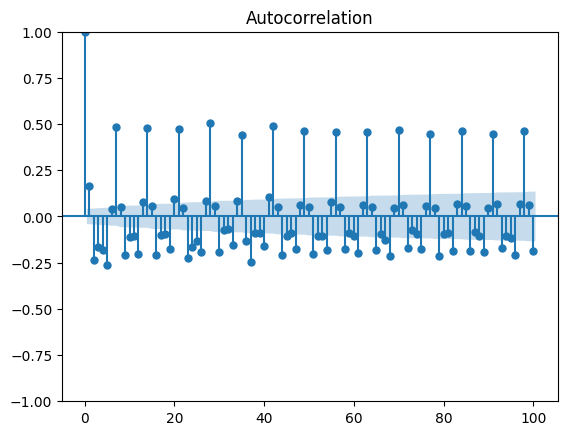

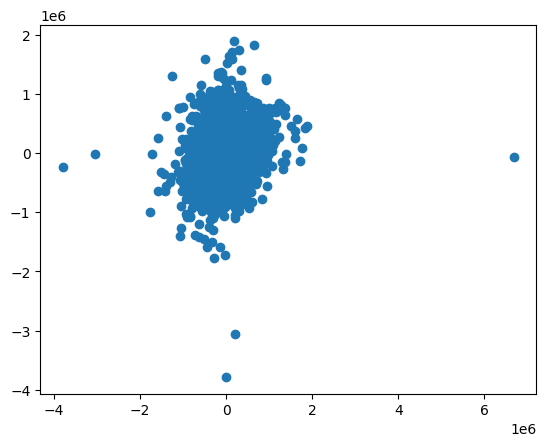

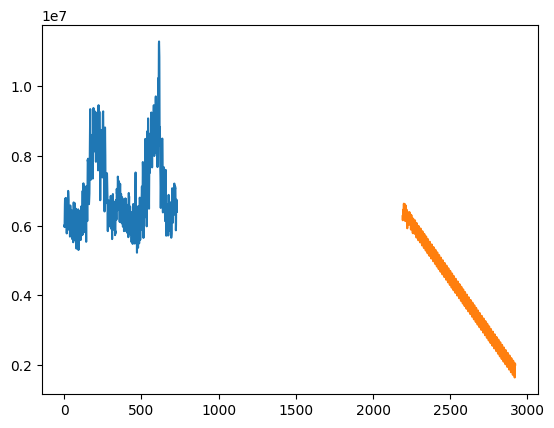

MSE: nan
RMSE: nan
MAE: nan
MAPE: nan


In [7]:
# KPSS test
#print(kpss(train['load_MW']))

# STL decomposition
# stl = STL(train['load_MW'], seasonal=13)
# res = stl.fit()
# fig = res.plot()

# SARIMA model using stepwise search
stepwise_model = auto_arima(train['load_MW'], start_p=1, start_q=1, max_p=30, max_q=30, m=12,
                            start_P=0, seasonal=True, d=1, D=1, trace=True,
                            error_action='ignore', suppress_warnings=True, stepwise=True)

print(stepwise_model.summary())

# Residual analysis
residuals = stepwise_model.resid()
plt.hist(residuals, bins=15)
plt.show()

plt.plot(residuals)
plt.show()

plot_acf(residuals, lags=100)
plt.show()

plt.scatter(residuals[:-1], residuals[1:])
plt.show()

# Forecasting
forecast = stepwise_model.predict(n_periods=len(test))
plt.plot(test['load_MW'].reset_index(drop=True))
plt.plot(forecast)
plt.show()

# Loss Metrics
print("MSE:", ((test['load_MW'].reset_index(drop=True) - forecast) ** 2).mean())
print("RMSE:", np.sqrt(((test['load_MW'].reset_index(drop=True) - forecast) ** 2).mean()))
print("MAE:", np.abs(test['load_MW'].reset_index(drop=True) - forecast).mean())
print("MAPE:", (np.abs((test['load_MW'].reset_index(drop=True) - forecast) / test['load_MW'].reset_index(drop=True))).mean() * 100)


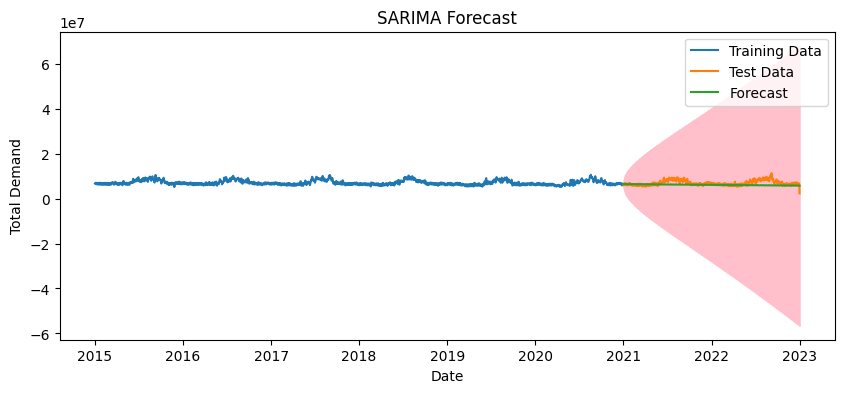

Mean Squared Error (MSE): 2129348930463.1116
Root Mean Squared Error (RMSE): 1459228.8821371072
Mean Absolute Error (MAE): 1047871.5761287037
Mean Absolute Percentage Error (MAPE): 0.13520386861827896


In [22]:
# second text file

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import numpy as np

# Load necessary libraries
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from math import sqrt

# Load and wrangle data
caiso_data = pd.read_csv("CAISO_data.csv")
caiso_data['date'] = pd.to_datetime(caiso_data['timestamp'].str[:10], format='%Y-%m-%d')
use_data = caiso_data.groupby('date').agg(total_demand=('load_MW', 'sum')).reset_index()

# Train-Test Split
train_size = int(len(use_data) * 0.75)
train, test = use_data[1:train_size], use_data[train_size:]

# Fit SARIMA model
# Note: You may need to experiment with the order and seasonal_order parameters to find the best fit
model = SARIMAX(train['total_demand'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
results = model.fit(disp=False)

# Make predictions
forecast = results.get_forecast(steps=len(test))
mean_forecast = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Plot results
plt.figure(figsize=(10, 4))
plt.plot(train['date'], train['total_demand'], label='Training Data')
plt.plot(test['date'], test['total_demand'], label='Test Data')
plt.plot(test['date'], mean_forecast, label='Forecast')
plt.fill_between(test['date'], confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], color='pink')
plt.legend()
plt.title('SARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Total Demand')
plt.show()

# Calculate loss metrics
mse = mean_squared_error(test['total_demand'], mean_forecast)
rmse = sqrt(mse)
mae = mean_absolute_error(test['total_demand'], mean_forecast)
mape = mean_absolute_percentage_error(test['total_demand'], mean_forecast)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Absolute Percentage Error (MAPE): {mape}')



In [27]:
results.save("sarima.pickle")

In [12]:
stepwise_model.predict(n_periods=5)

2192    6.267528e+06
2193    6.150815e+06
2194    6.270511e+06
2195    6.323537e+06
2196    6.455770e+06
dtype: float64

In [15]:
import pickle as pkl

In [16]:
class SARIMA_model:
    """Wrapper on our pre-trained shit"""
    def __init__(self, stepwise_model):
        self.model = stepwise_model
    
    def fit(self, X):
        self.model = stepwise_model(X, start_p=1, start_q=1, max_p=30, max_q=30, m=12,
                            start_P=0, seasonal=True, d=1, D=1, trace=True,
                            error_action='ignore', suppress_warnings=True, stepwise=True)
    
    def predict(n_periods=5):
        return self.model(n_periods=n_periods)

In [17]:
model = SARIMA_model(stepwise_model)

In [19]:
with open('sarima.pickle', 'wb') as handle:
    pkl.dump(model, handle)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=b82b9643-cfd7-4eed-98d3-bc210272c836' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>